In [1]:
%pip install pycaret

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pycaret.datasets import get_data
airline = get_data('airline').reset_index()
airline['Period'] = airline['Period'].dt.to_timestamp()
airline.set_index('Period', inplace=True)

,Number of airline passengers
Period,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


In [4]:
airline.head()

,Number of airline passengers
Period,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [5]:
airline.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Period', length=144, freq=None)

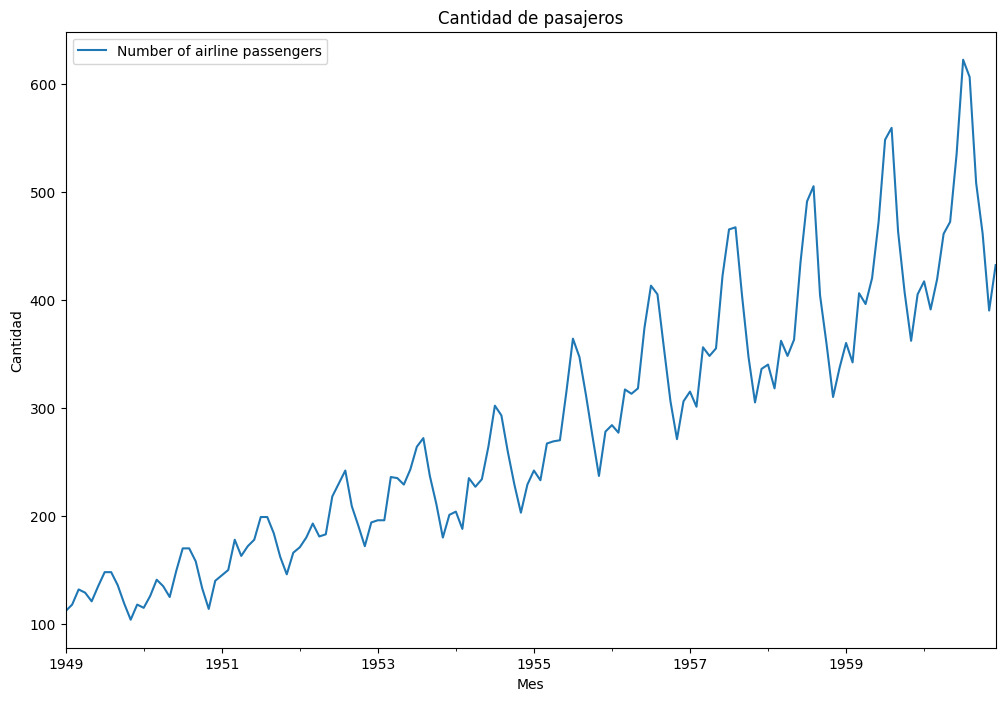

In [6]:
airline['Number of airline passengers'].plot(figsize=(12, 8))
plt.title('Cantidad de pasajeros')
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.legend()
plt.show()

# Modelos ML: intuiciones

Vamos a usar 1 arbol de decisión con 2 lags de dato para hacer nuestro primer forecasting con ML

In [7]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [8]:
airline['Lag_1'] = airline['Number of airline passengers'].shift(1)
airline['Lag_2'] = airline['Number of airline passengers'].shift(2)
airline = airline.dropna()

airline.head()

,Number of airline passengers,Lag_1,Lag_2
Period,,,
1949-03-01,132.0,118.0,112.0
1949-04-01,129.0,132.0,118.0
1949-05-01,121.0,129.0,132.0
1949-06-01,135.0,121.0,129.0
1949-07-01,148.0,135.0,121.0


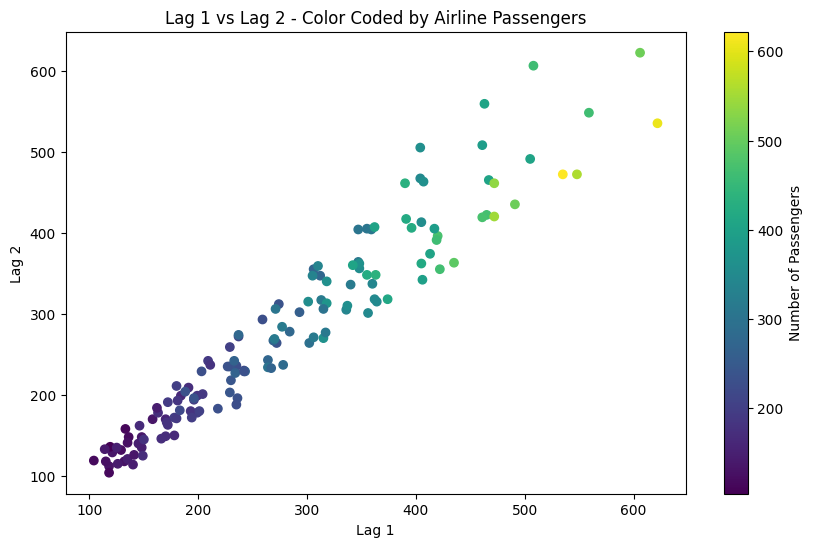

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(airline['Lag_1'], airline['Lag_2'], c=airline['Number of airline passengers'], cmap='viridis')
plt.title('Lag 1 vs Lag 2 - Color Coded by Airline Passengers')
plt.xlabel('Lag 1')
plt.ylabel('Lag 2')
plt.colorbar(label='Number of Passengers')
plt.show()

In [10]:
X = airline[['Lag_1', 'Lag_2']]
y = airline['Number of airline passengers']

model = DecisionTreeRegressor(max_depth=2)
model.fit(X, y)

airline['dt_predictions'] = model.predict(X)

airline.head()

,Number of airline passengers,Lag_1,Lag_2,dt_predictions
Period,,,,
1949-03-01,132.0,118.0,112.0,164.538462
1949-04-01,129.0,132.0,118.0,164.538462
1949-05-01,121.0,129.0,132.0,164.538462
1949-06-01,135.0,121.0,129.0,164.538462
1949-07-01,148.0,135.0,121.0,164.538462


Vamos a graficar el modelo

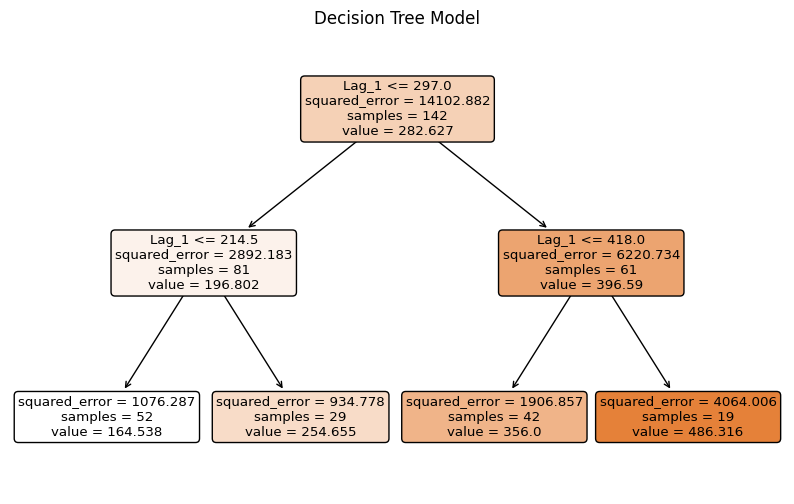

In [11]:
plt.figure(figsize=(10, 6))
plot_tree(model, feature_names=['Lag_1', 'Lag_2'], filled=True, rounded=True)
plt.title('Decision Tree Model')
plt.show()

Ahora vamos a ver donde se hicieron los puntos de corte

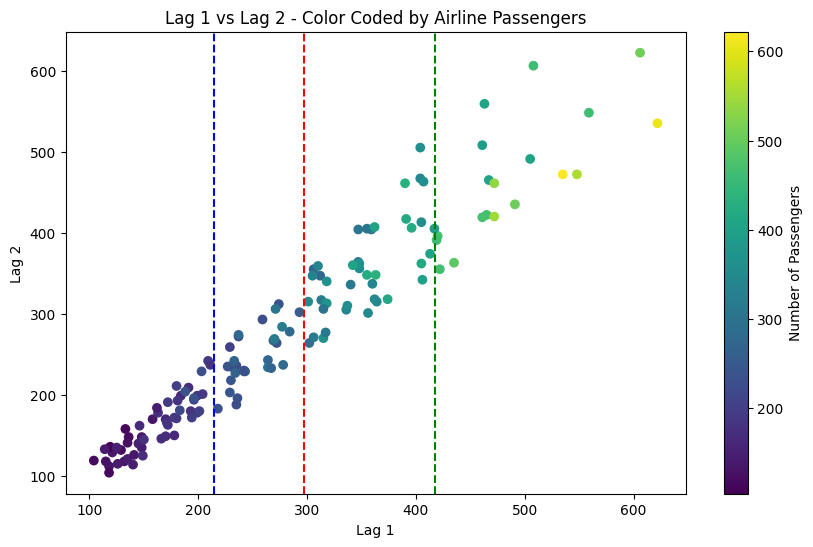

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(airline['Lag_1'], airline['Lag_2'], c=airline['Number of airline passengers'], cmap='viridis')

plt.axvline(x=297, color='red', linestyle='--')
plt.axvline(x=214.5, color='blue', linestyle='--')
plt.axvline(x=418, color='green', linestyle='--')

plt.title('Lag 1 vs Lag 2 - Color Coded by Airline Passengers')
plt.xlabel('Lag 1')
plt.ylabel('Lag 2')
plt.colorbar(label='Number of Passengers')
plt.show()

Ahora visualicemos la predicción

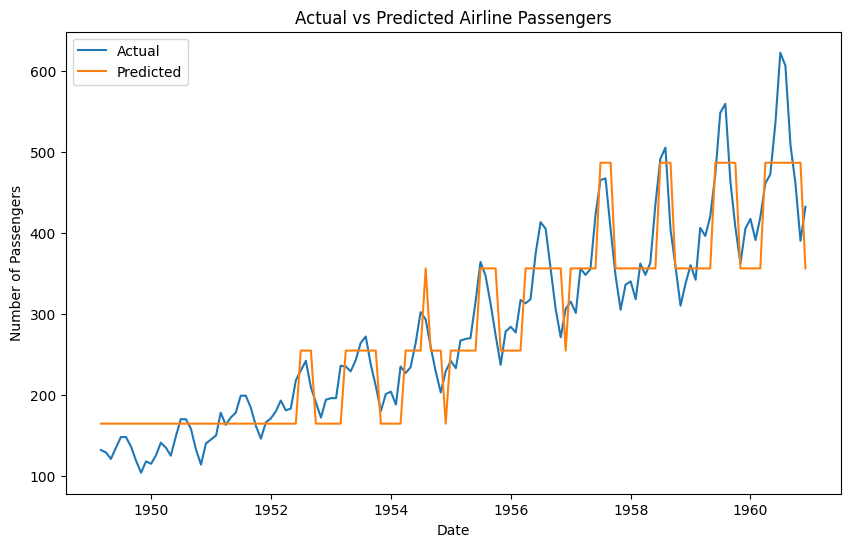

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(airline.index, airline['Number of airline passengers'], label='Actual')
plt.plot(airline.index, airline['dt_predictions'], label='Predicted')
plt.title('Actual vs Predicted Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

Mientra aumenta el depth del arbol de decisión, el modelo se va fitteando cada vez más a los datos. Vamos a usar ahora XGBoost y ver que pasa

In [14]:
from xgboost import XGBRegressor

xgboost_model = XGBRegressor(n_estimators=100)
xgboost_model.fit(X, y)

airline['xgboost_predictions'] = xgboost_model.predict(X)
airline.head()

,Number of airline passengers,Lag_1,Lag_2,dt_predictions,xgboost_predictions
Period,,,,,
1949-03-01,132.0,118.0,112.0,164.538462,131.753448
1949-04-01,129.0,132.0,118.0,164.538462,129.078384
1949-05-01,121.0,129.0,132.0,164.538462,121.399040
1949-06-01,135.0,121.0,129.0,164.538462,134.985535
1949-07-01,148.0,135.0,121.0,164.538462,147.379028


graficando

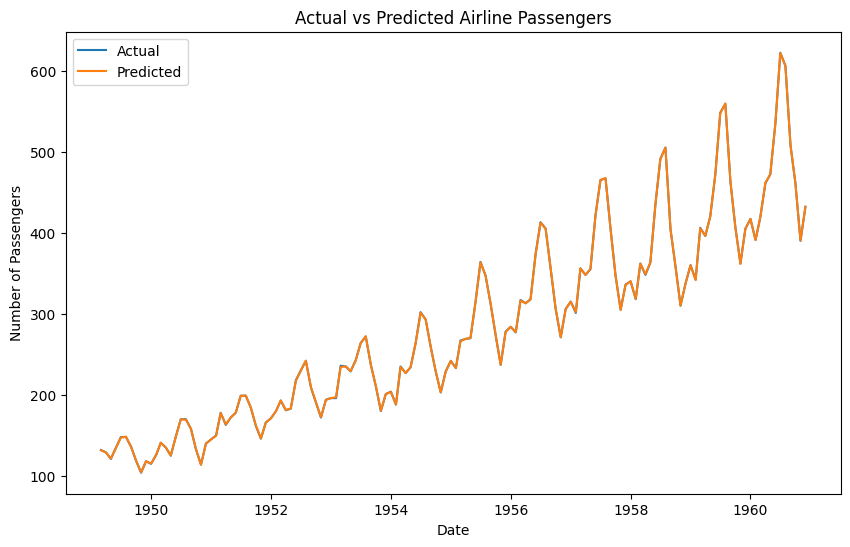

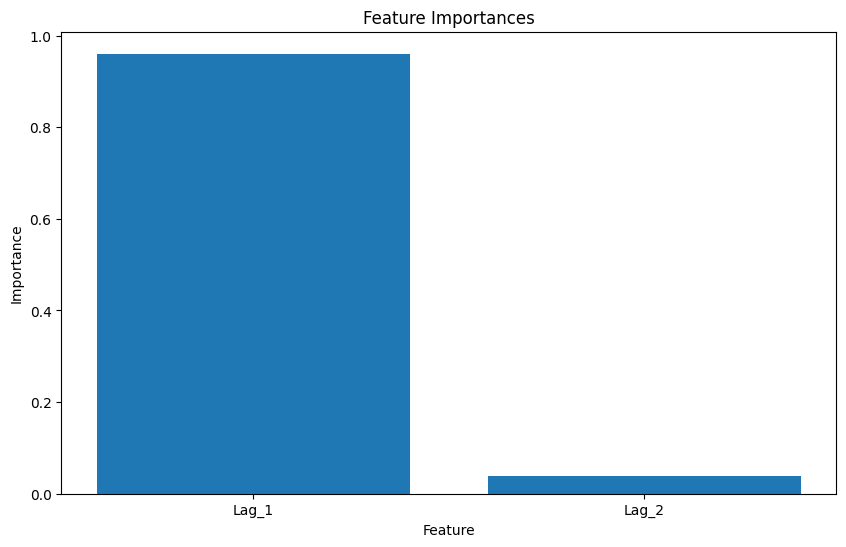

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(airline.index, airline['Number of airline passengers'], label='Actual')
plt.plot(airline.index, airline['xgboost_predictions'], label='Predicted')
plt.title('Actual vs Predicted Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

importances = xgboost_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(X.columns, importances)
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


perfectamente fitteado. Buenísimo no? (overfitting capaz)

Pero el problema no va a ser el overfitting ahora... veamos la predicción de datos no entrenados.

In [16]:
h = 36 # number of steps to forecast into the future
def forecast_future(dt_model, data, steps=h):
    # Starting with the last known lag values
    last_lag1 = data['Lag_1'].iloc[-1]
    last_lag2 = data['Lag_2'].iloc[-1]

    # To store future predictions
    future_predictions = []

    for step in range(steps):
        # Format the input with the correct column names
        input_df = pd.DataFrame([[last_lag1, last_lag2]], columns=['Lag_1', 'Lag_2'])

        # Predict the next value
        next_value_pred = dt_model.predict(input_df)[0]

        # Update lag values
        last_lag2 = last_lag1
        last_lag1 = next_value_pred

        future_predictions.append(next_value_pred)

    return future_predictions

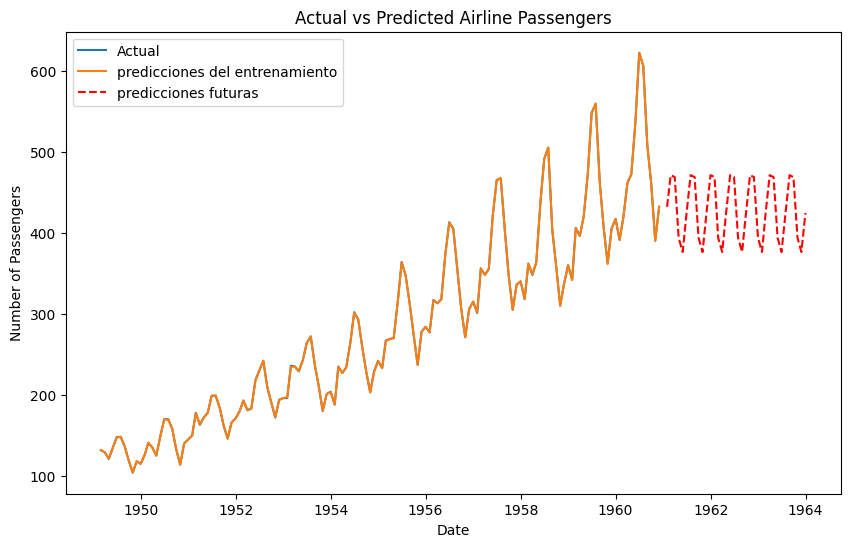

In [17]:
predicciones_futuras = forecast_future(xgboost_model, airline)

last_date = airline.index[-1]
fechas_futuras = pd.date_range(start=last_date, periods=h+1, freq='M')[1:]

# graficando
plt.figure(figsize=(10, 6))
plt.plot(airline.index, airline['Number of airline passengers'], label='Actual')
plt.plot(airline.index, airline['xgboost_predictions'], label='predicciones del entrenamiento')
plt.plot(fechas_futuras, predicciones_futuras, label='predicciones futuras', linestyle='--', color='red')
plt.title('Actual vs Predicted Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


Muy buena predicción no?

Agregemos más lags a ver que pasa

In [18]:
from pycaret.datasets import get_data
airline_2 = get_data('airline').reset_index()
airline_2['Period'] = airline_2['Period'].dt.to_timestamp()
airline_2.set_index('Period', inplace=True)

,Number of airline passengers
Period,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


In [19]:
for i in range(1, 13):
    airline_2[f'Lag_{i}'] = airline_2['Number of airline passengers'].shift(i)

airline_2.dropna(inplace=True)
airline_2.head()

,Number of airline passengers,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12
Period,,,,,,,,,,,,,
1950-01-01,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0
1950-02-01,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0
1950-03-01,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0
1950-04-01,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0
1950-05-01,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0


In [20]:
X=airline_2.drop('Number of airline passengers', axis=1)
y=airline_2['Number of airline passengers']

xgboost_model_12lags = XGBRegressor(n_estimators=100)
xgboost_model_12lags.fit(X, y)

airline_2['xgboost_predictions_12lags'] = xgboost_model_12lags.predict(X)
airline_2.head()

,Number of airline passengers,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,xgboost_predictions_12lags
Period,,,,,,,,,,,,,,
1950-01-01,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,114.999489
1950-02-01,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,126.000626
1950-03-01,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,141.000168
1950-04-01,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,135.002197
1950-05-01,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,125.000343


In [21]:
h = 36 # number of steps to forecast into the future
def forecast_future(dt_model, data, steps=h):
    # Starting with the last known lag values
    last_lags = data[[f'Lag_{i}' for i in range(1, 13)]].iloc[-1].values.tolist()

    # To store future predictions
    future_predictions = []

    for step in range(steps):
        # Format the input with the correct column names
        input_df = pd.DataFrame([last_lags], columns=[f'Lag_{i}' for i in range(1, 13)])

        # Predict the next value
        next_value_pred = dt_model.predict(input_df)[0]

        # Update lag values
        last_lags = [next_value_pred] + last_lags[:-1]

        future_predictions.append(next_value_pred)

    return future_predictions

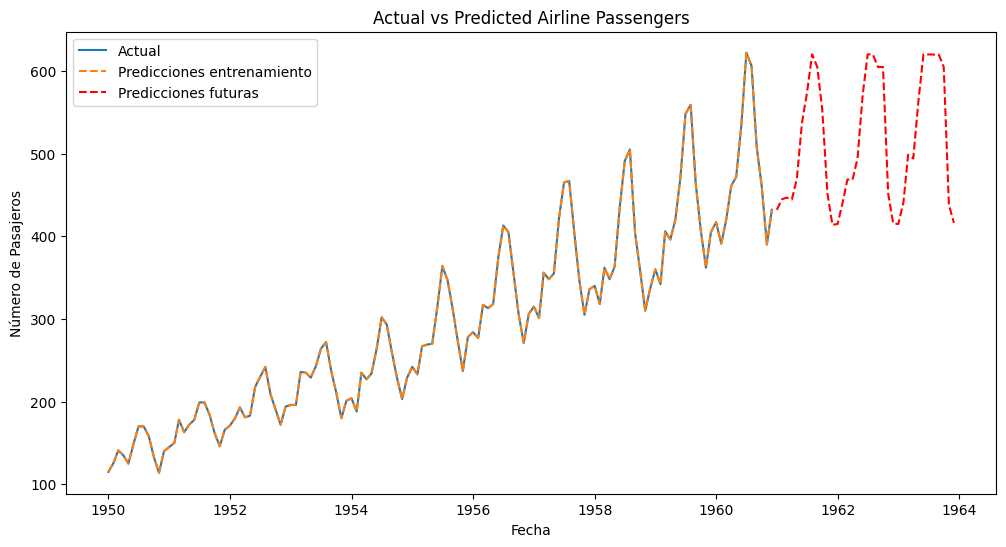

In [22]:
# 1. Predecir el futuro con solo las variables necesarias
lags_df = airline_2[[f'Lag_{i}' for i in range(1, 13)]]
predicciones_futuras_12lags = forecast_future(xgboost_model_12lags, lags_df)

# 2. Generar fechas futuras
last_date = airline_2.index[-1]
fechas_futuras = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=h, freq='M')

# 3. Graficar
plt.figure(figsize=(12, 6))
plt.plot(airline_2.index, airline_2['Number of airline passengers'], label='Actual')
plt.plot(airline_2.index, airline_2['xgboost_predictions_12lags'], label='Predicciones entrenamiento', linestyle='--')
plt.plot(fechas_futuras, predicciones_futuras_12lags, label='Predicciones futuras', linestyle='--', color='red')
plt.title('Actual vs Predicted Airline Passengers')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.legend()
plt.show()



Ahora mucho mejor pero... Que está faltando???

Los modelos de machine learning no son buenos capturando la tendencia y la estacionalidad por si solos.

Estos modelos funcionan mejor con datos estacionarios, es decir, que mantengan propiedades estadísiticas en el tiempo.

Para eso, vamos a hacer feature engineering para eliminar tendencia y desestacionalizar

Vamos a cargar por 3era vez el dataset

In [23]:
from pycaret.datasets import get_data
airline_3 = get_data('airline').reset_index()
airline_3['Period'] = airline_3['Period'].dt.to_timestamp()
airline_3.set_index('Period', inplace=True)

,Number of airline passengers
Period,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


Vamos a aplicar LOG y luego descomponer la serie

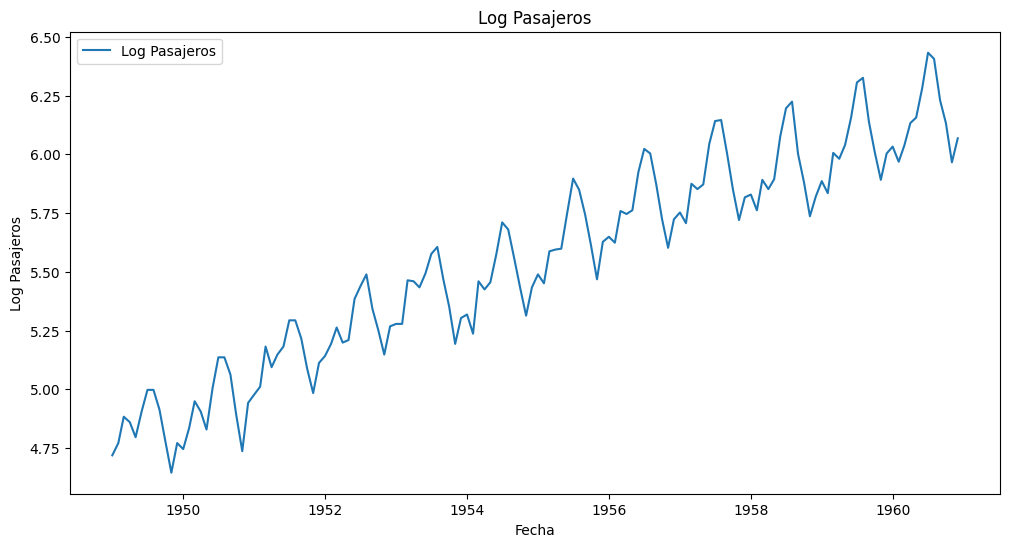

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

airline_3['log_passengers'] = np.log(airline_3['Number of airline passengers'])

#graficando el log passengers
plt.figure(figsize=(12, 6))
plt.plot(airline_3.index, airline_3['log_passengers'], label='Log Pasajeros')
plt.title('Log Pasajeros')
plt.xlabel('Fecha')
plt.ylabel('Log Pasajeros')
plt.legend()
plt.show()

In [25]:
decomposition = seasonal_decompose(airline_3['log_passengers'], model='additive', period=12)
airline_3['desestacionalizado_detrending'] = airline_3['log_passengers'] - decomposition.seasonal - decomposition.trend

# Creo 12 lags para la serie desestacionalizada y sin tendencia
for i in range(1, 13):
    airline_3[f'lag_{i}'] = airline_3['desestacionalizado_detrending'].shift(i)

airline_3.dropna(inplace=True)

# Mostrar las primeras filas para verificar
airline_3.head()


,Number of airline passengers,log_passengers,desestacionalizado_detrending,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Period,,,,,,,,,,,,,,,
1950-07-01,170.0,5.135798,-0.015501,-0.035148,-0.075473,0.014028,0.037236,0.069306,-0.039093,0.011045,0.005749,0.003156,0.001223,-0.048415,-0.050884
1950-08-01,170.0,5.135798,-0.026120,-0.015501,-0.035148,-0.075473,0.014028,0.037236,0.069306,-0.039093,0.011045,0.005749,0.003156,0.001223,-0.048415
1950-09-01,158.0,5.062595,0.023379,-0.026120,-0.015501,-0.035148,-0.075473,0.014028,0.037236,0.069306,-0.039093,0.011045,0.005749,0.003156,0.001223
1950-10-01,133.0,4.890349,-0.026322,0.023379,-0.026120,-0.015501,-0.035148,-0.075473,0.014028,0.037236,0.069306,-0.039093,0.011045,0.005749,0.003156
1950-11-01,114.0,4.736198,-0.061051,-0.026322,0.023379,-0.026120,-0.015501,-0.035148,-0.075473,0.014028,0.037236,0.069306,-0.039093,0.011045,0.005749


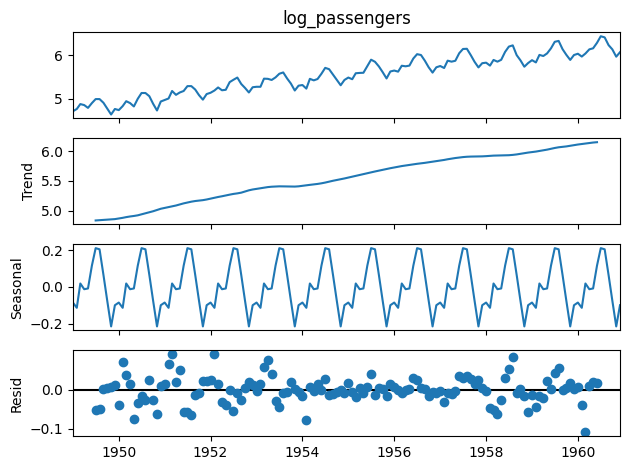

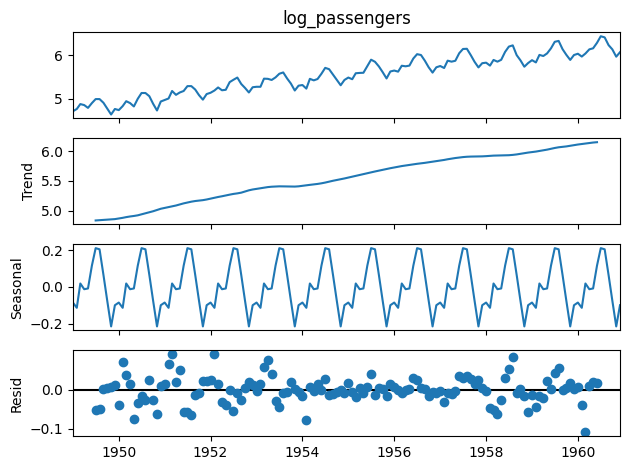

In [26]:
decomposition.plot()

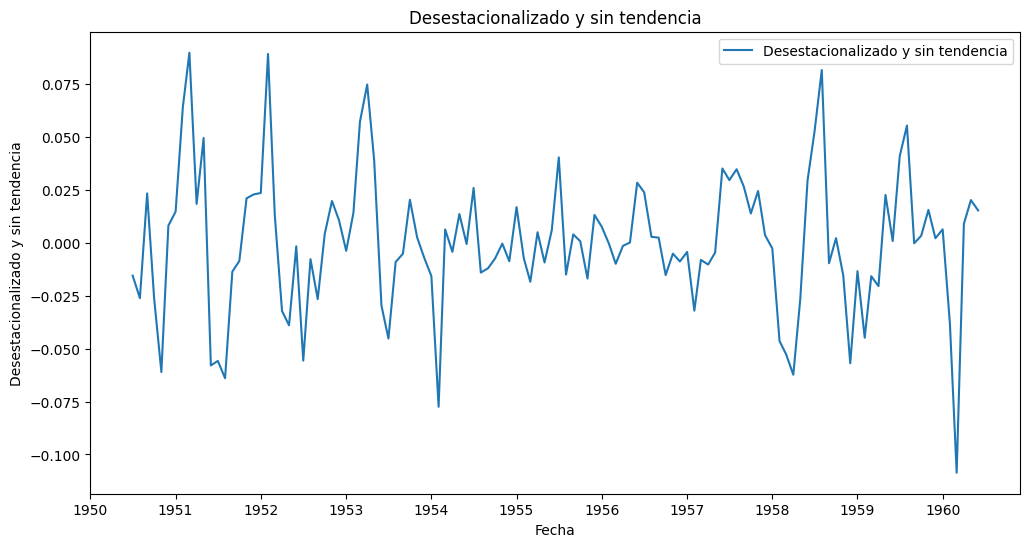

In [27]:
# graficamos desestacionalizado y detrending
plt.figure(figsize=(12, 6))
plt.plot(airline_3.index, airline_3['desestacionalizado_detrending'], label='Desestacionalizado y sin tendencia')
plt.title('Desestacionalizado y sin tendencia')
plt.xlabel('Fecha')
plt.ylabel('Desestacionalizado y sin tendencia')
plt.legend()
plt.show()

Entrenamos el modelo

In [28]:
X = airline_3.drop(['Number of airline passengers', 'log_passengers', 'desestacionalizado_detrending'], axis=1)
y = airline_3['desestacionalizado_detrending']

xgboost_model_desestacionalizado = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgboost_model_desestacionalizado.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Predecimos

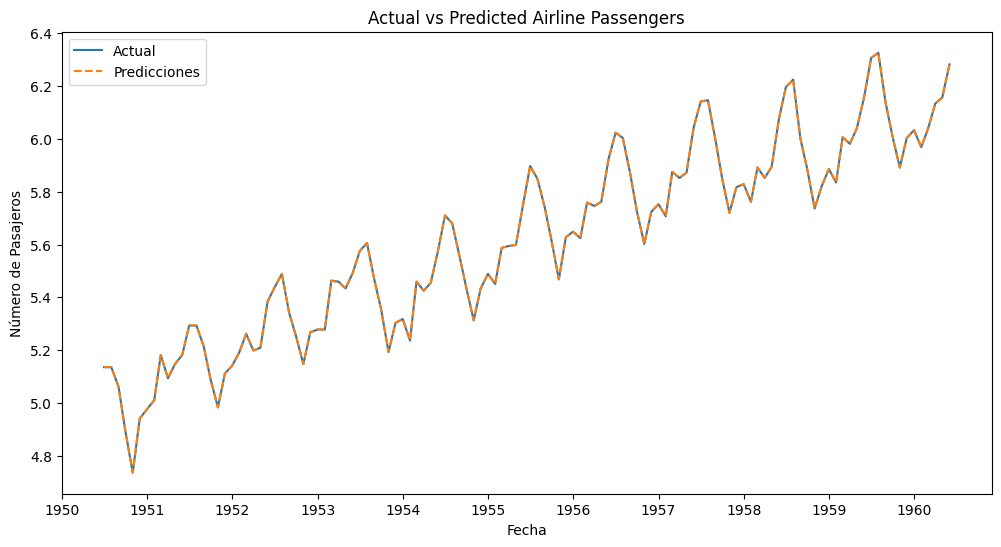

In [29]:
y_pred = xgboost_model_desestacionalizado.predict(X)

# Retrending y Reseasonalizing
airline_3['xgboost_pred'] = y_pred + decomposition.seasonal.reindex(airline_3.index) + decomposition.trend.reindex(airline_3.index)

#graficamos (si queremos ver los valores originales se exponencia todo con np.exp(airline_3['log_passengers']))
plt.figure(figsize=(12, 6))
plt.plot(airline_3.index, airline_3['log_passengers'], label='Actual')
plt.plot(airline_3.index, airline_3['xgboost_pred'], label='Predicciones', linestyle='--')
plt.title('Actual vs Predicted Airline Passengers')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.legend()
plt.show()


In [30]:
def forecast_future_ds(model, data, decomposition, steps=36):
    # Obtener los últimos 12 lags conocidos (cuidado con el nombre: 'lag_' en minúscula)
    last_lags = [data[f'lag_{i}'].iloc[-1] for i in range(1, 13)]

    future_predictions = []

    # Extraer componentes
    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal.dropna()

    # Tomar último valor de tendencia conocido y su pendiente aproximada
    last_known_trend = trend.iloc[-1]
    trend_diff = trend.iloc[-1] - trend.iloc[-2] if len(trend) >= 2 else 0

    # Obtener ciclo estacional de los últimos 12 valores
    seasonal_cycle = seasonal[-12:].tolist()

    for step in range(steps):
        # Crear DataFrame de entrada con los 12 lags actuales
        input_df = pd.DataFrame([last_lags], columns=[f'lag_{i}' for i in range(1, 13)])

        # Predecir siguiente valor desestacionalizado y sin tendencia
        next_value = model.predict(input_df)[0]

        # Extrapolar tendencia: tendencia lineal
        next_trend = last_known_trend + trend_diff * (step + 1)

        # Obtener componente estacional en la posición correspondiente del ciclo
        next_seasonal = seasonal_cycle[step % 12]

        # Reconstruir valor completo
        full_prediction = next_value + next_trend + next_seasonal
        future_predictions.append(full_prediction)

        # Actualizar lags para la próxima predicción
        last_lags = [next_value] + last_lags[:-1]

    return future_predictions



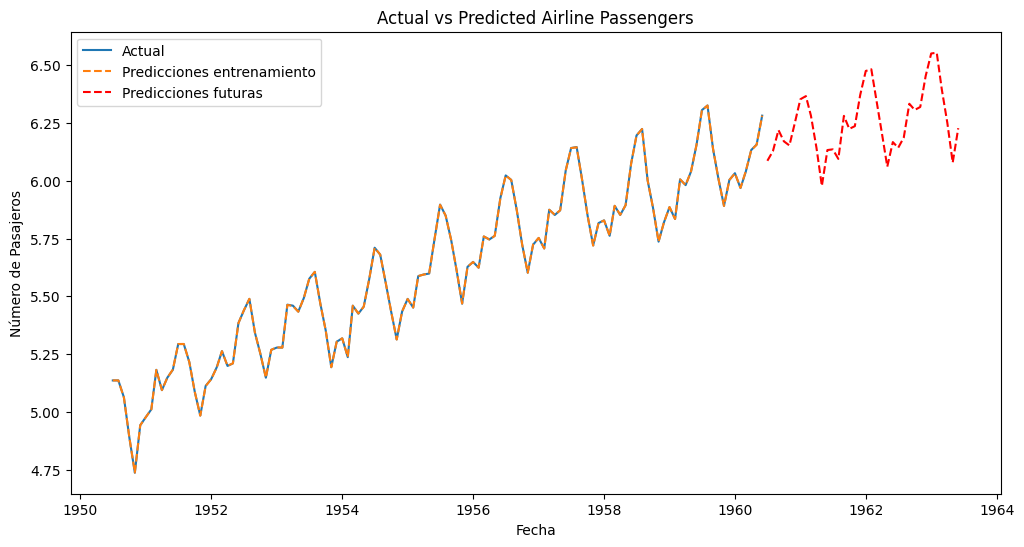

In [31]:
h = 36
predicciones_futuras_12lags = forecast_future_ds(xgboost_model_desestacionalizado, airline_3, decomposition, steps=h)

fechas_futuras = pd.date_range(start=airline_3.index[-1] + pd.offsets.MonthEnd(1), periods=h, freq='M')


# graficando
plt.figure(figsize=(12, 6))
plt.plot(airline_3.index, airline_3['log_passengers'], label='Actual')
plt.plot(airline_3.index, airline_3['xgboost_pred'], label='Predicciones entrenamiento', linestyle='--')
plt.plot(fechas_futuras, predicciones_futuras_12lags, label='Predicciones futuras', linestyle='--', color='red')
plt.title('Actual vs Predicted Airline Passengers')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.legend()
plt.show()

## PYCARET

In [32]:
from pycaret.datasets import get_data
from pycaret.time_series import *
airline = get_data('airline')

,Number of airline passengers
Period,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


In [33]:
airline.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', length=144)

In [34]:
exp = TSForecastingExperiment()
exp.setup(data = airline, target='Number of airline passengers' ,  fh = 12, coverage=0.95)

,Description,Value
0,session_id,8493
1,Target,Number of airline passengers
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(144, 1)"
5,Transformed data shape,"(144, 1)"
6,Transformed train set shape,"(132, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [35]:
exp.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,144.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,280.298611
3,Summary,Statistics,Transformed,Median,,265.5
4,Summary,Statistics,Transformed,Standard Deviation,,119.966317
5,Summary,Statistics,Transformed,Variance,,14391.917201
6,Summary,Statistics,Transformed,Kurtosis,,-0.364942
7,Summary,Statistics,Transformed,Skewness,,0.58316
8,Summary,Statistics,Transformed,# Distinct Values,,118.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",1606.083817


In [36]:
exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,0.5716,0.5997,16.7778,19.7963,0.0422,0.0427,0.8954,0.1233
ets,ETS,0.5931,0.6212,17.4165,20.5102,0.0440,0.0445,0.8882,0.1900
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.6660,0.7342,19.6496,24.3006,0.0489,0.0488,0.8428,0.6567
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.6813,0.7866,20.0334,25.9670,0.0491,0.0499,0.8113,0.3700
arima,ARIMA,0.6830,0.6735,20.0069,22.2199,0.0501,0.0507,0.8677,0.3167
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.7004,0.7702,20.6084,25.4401,0.0509,0.0514,0.8215,0.7333
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.7004,0.7703,20.6086,25.4405,0.0509,0.0514,0.8215,0.3533
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.7029,0.7732,20.6816,25.5362,0.0511,0.0516,0.8201,0.5200
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.7048,0.7751,20.7373,25.6005,0.0512,0.0517,0.8193,0.3533
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.7048,0.7751,20.7366,25.6009,0.0512,0.0517,0.8192,0.3533


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

ExponentialSmoothing(seasonal='mul', sp=12, trend='add')

In [38]:
light_gbm_model = exp.create_model('lightgbm_cds_dt', cross_validation=False)
tuned_lgbm = exp.tune_model(light_gbm_model, optimize = 'MAPE')


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,0.8837,0.9749,26.9090,33.6827,0.0531,0.0549,0.7952


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,1956-12,0.8361,0.9191,24.4159,30.0856,0.0678,0.0660,0.7054
1,1957-12,1.3979,1.3482,42.7374,45.7716,0.1176,0.1106,0.4512
2,1958-12,1.2476,1.4247,35.6498,46.3101,0.0765,0.0808,0.5202
Mean,NaT,1.1605,1.2307,34.2677,40.7224,0.0873,0.0858,0.5589
SD,NaT,0.2375,0.2225,7.5433,7.5246,0.0217,0.0185,0.1073


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.2s finished


In [39]:
exp.plot_model(tuned_lgbm, plot = 'forecast', data_kwargs = {'fh': 24})

In [40]:
xgboost_model = exp.create_model('xgboost_cds_dt', cross_validation=False)
tuned_xgboost = exp.tune_model(xgboost_model, optimize = 'MAPE')

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,0.8125,0.8605,24.7411,29.7286,0.0489,0.0503,0.8405


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,1956-12,0.3438,0.4259,10.0402,13.9424,0.0257,0.0262,0.9367
1,1957-12,0.6964,0.7731,21.2898,26.2453,0.0583,0.0559,0.8195
2,1958-12,0.6496,0.6525,18.5615,21.2112,0.0425,0.0436,0.8993
Mean,NaT,0.5633,0.6172,16.6305,20.4663,0.0422,0.0419,0.8852
SD,NaT,0.1563,0.1439,4.7913,5.0502,0.0133,0.0122,0.0489


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.9s finished


In [42]:
exp.plot_model(tuned_xgboost, plot = 'forecast', data_kwargs = {'fh': 24})